## Colab setup

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Use TensorFlow 2.0. Save package versions to `requirements.txt`.
!pip install tensorflow-gpu==2.0.0
!pip freeze > /content/drive/My\ Drive/finding-houses/requirements.txt

     |████████████████████████████████| 380.8MB 40kB/s 
     |████████████████████████████████| 450kB 57.3MB/s 
     |████████████████████████████████| 3.8MB 67.8MB/s 
     |████████████████████████████████| 81kB 12.4MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goo

## `train.py`

In [0]:
# SETUP ------------------------------------------------------------------------

import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import load_img

# Set base filepath. Import helper functions.
path = '/content/drive/My Drive/finding-houses/'
sys.path.insert(0, path)
from helper_functions import *

# DATA -------------------------------------------------------------------------

# Load training data. Convert label image to one-hot encoding.
x_all = np.array(load_img(path+'images/rgb.png', color_mode='rgb'))
y_all = np.array(load_img(path+'images/gt.png', color_mode='grayscale')) // 255
y_all = tf.keras.utils.to_categorical(y_all, num_classes=2, dtype=np.uint8)

# Reserve 256px-high strip of training images for validation.
x_train = x_all[256:]
x_valid = x_all[:256]
y_train = y_all[256:]
y_valid = y_all[:256]

# Crop x_valid and y_valid at the red line shown in `x_valid_uncropped.png`.
j0 = (x_valid.shape[1] % 256) + 256
x_valid = x_valid[:, j0:]
y_valid = y_valid[:, j0:]

# Split x_valid and y_valid into 256x256px frames.
num_splits = x_valid.shape[1] // 256
x_valid = np.array(np.split(x_valid, num_splits, axis=1))
y_valid = np.array(np.split(y_valid, num_splits, axis=1))

# Sample training frames. Bundle validation data.
x, y = sample_training_data(x_train, y_train, num_examples=40000)
xy_valid = (x_valid, y_valid)

# MODEL ------------------------------------------------------------------------

# Implement model as specified in instructions.
model = tf.keras.models.Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', input_shape=(256, 256, 3)),
    Activation('relu'),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=(3, 3), padding='same'),
    Activation('relu'),
    UpSampling2D(size=(2, 2)),
    Conv2D(filters=2, kernel_size=(5, 5), padding='same')])

# Use binary cross-entropy loss and Adam optimiser.
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

# TRAINING ---------------------------------------------------------------------

# Train model for 50 epochs.
history = model.fit(x, y, batch_size=256, epochs=50, validation_data=xy_valid)

# Save trained model and in-training metric values.
model.save(path+'training/model.h5')
metrics = pd.DataFrame({
    'loss_train':history.history['loss'],
    'loss_valid':history.history['val_loss'],
    'acc_train':history.history['accuracy'],
    'acc_valid':history.history['val_accuracy']})
metrics.to_csv(path+'training/metrics.csv', index=False)

Train on 40000 samples, validate on 6 samples
Epoch 1/50
40000/40000 [==============================] - 80s 2ms/sample - loss: 0.4002 - accuracy: 0.9037 - val_loss: 0.4600 - val_accuracy: 0.9424
Epoch 2/50
40000/40000 [==============================] - 72s 2ms/sample - loss: 0.1670 - accuracy: 0.9534 - val_loss: 0.5528 - val_accuracy: 0.9446
Epoch 3/50
40000/40000 [==============================] - 72s 2ms/sample - loss: 0.1555 - accuracy: 0.9565 - val_loss: 0.7338 - val_accuracy: 0.9487
Epoch 4/50
40000/40000 [==============================] - 72s 2ms/sample - loss: 0.1493 - accuracy: 0.9577 - val_loss: 0.7893 - val_accuracy: 0.9505
Epoch 5/50
40000/40000 [==============================] - 72s 2ms/sample - loss: 0.1400 - accuracy: 0.9595 - val_loss: 0.6717 - val_accuracy: 0.9504
Epoch 6/50
40000/40000 [==============================] - 72s 2ms/sample - loss: 0.1362 - accuracy: 0.9597 - val_loss: 0.6101 - val_accuracy: 0.9525
Epoch 7/50
40000/40000 [==============================] - 72

## `predict.py`

In [0]:
# SETUP ------------------------------------------------------------------------

import sys
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img

# Set base filepath. Import helper functions.
path = '/content/drive/My Drive/finding-houses/'
sys.path.insert(0, path)
from helper_functions import *

# DATA -------------------------------------------------------------------------

# Load input image.
x = np.array(load_img(path+'images/rgb.png', color_mode='rgb'))

# Pad input image so that width and height are multiples of 256px.
x_pad = np.pad(x, pad_width=(
    (0, 256-(x.shape[0]%256)), # axis 0
    (0, 256-(x.shape[1]%256)), # axis 1
    (0, 0))) # axis 2

# Split input image into 256x256px frames.
x_split = []
Ni = x_pad.shape[0] // 256
Nj = x_pad.shape[1] // 256
for i in range(Ni):
    for j in range(Nj):
        x_split.append(x_pad[(i*256):(i*256)+256, (j*256):(j*256)+256])
x_split = np.array(x_split)

# PREDICTIONS ------------------------------------------------------------------

# Load trained model.
model = tf.keras.models.load_model(path+'training/model.h5')

# Compute predictions. Merge into single image. Crop back to original size.
yhat_split = model.predict(x_split.astype(np.float32))
yhat = np.concatenate(
    [np.concatenate(row, axis=1) for row in np.split(yhat_split, Ni, axis=0)],
    axis=0)

# Save predictions, cropped to input image size.
yhat = yhat[:x.shape[0], :x.shape[1]]
np.save(path+'predictions/train_valid_logit.npy', yhat)
np.save(path+'predictions/train_valid_proba.npy', sigmoid(yhat))

## `visualise.py`

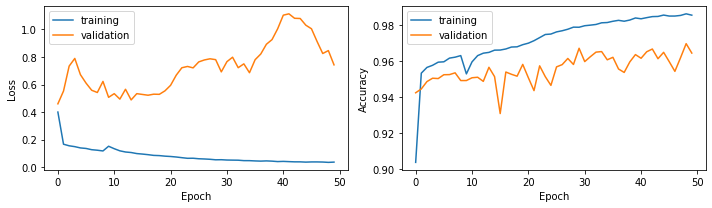

In [0]:
# SETUP ------------------------------------------------------------------------

import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

# Set base filepath. Import helper functions.
path = '/content/drive/My Drive/finding-houses/'
sys.path.insert(0, path)
from helper_functions import *

# Set parameters for saving images.
img_params = dict(dpi=300, bbox_inches='tight', transparent=True, pad_inches=0) 

# DATA -------------------------------------------------------------------------

# Load input image, label image, predictions, in-training metric values.
x = np.array(load_img(path+'images/rgb.png', color_mode='rgb'))
y = np.array(load_img(path+'images/gt.png', color_mode='grayscale')) // 255
y = tf.keras.utils.to_categorical(y, num_classes=2, dtype=np.uint8)
yhat = np.load(path+'predictions/train_valid_proba.npy')
metrics = pd.read_csv(path+'training/metrics.csv')

# VISUALISATION ----------------------------------------------------------------

# Show in-training metric values.
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(metrics['loss_train'], label='training')
axes[0].plot(metrics['loss_valid'], label='validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot(metrics['acc_train'], label='training')
axes[1].plot(metrics['acc_valid'], label='validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout()
plt.savefig(path+'training/metrics.png', dpi=300)

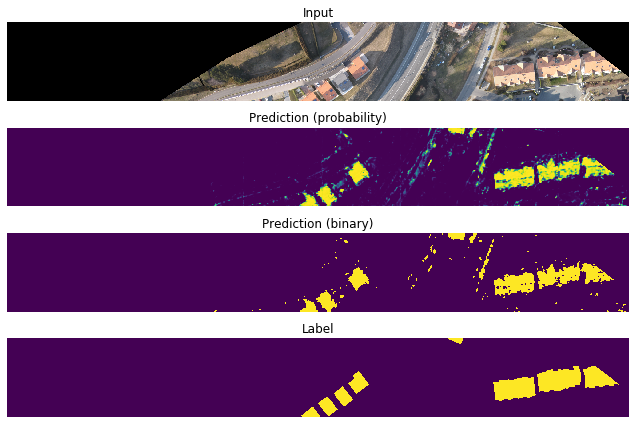

In [0]:
# Show validation data.
fig, axes = plt.subplots(4, 1, figsize=(10, 6))
axes[0].imshow(x[:256])
axes[0].set_title('Input')
axes[1].imshow(yhat[:256, :, 0])
axes[1].set_title('Prediction (probability)')
axes[2].imshow(yhat[:256, :, 0]>0.5)
axes[2].set_title('Prediction (binary)')
axes[3].imshow(y[:256, :, 0])
axes[3].set_title('Label')
[ax.axis('off') for ax in axes]
plt.tight_layout()
plt.savefig(path+'predictions/valid_comparison.png', **img_params)

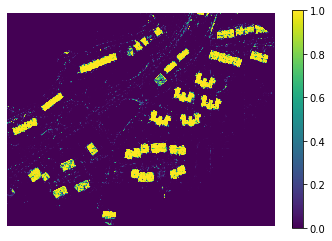

In [0]:
# Show predictions (probabilities) on whole input image.
plt.imshow(yhat[:, :, 0])
plt.axis('off')
plt.colorbar()
plt.savefig(path+'predictions/train_valid_proba.png', **img_params)

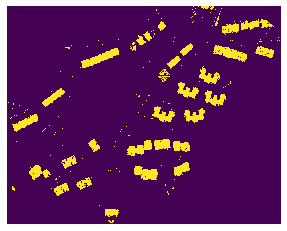

In [0]:
# Show predictions (binary) on whole input image.
plt.imshow(yhat[:, :, 0]>0.5)
plt.axis('off')
plt.savefig(path+'predictions/train_valid_binary_rgb.png', **img_params)

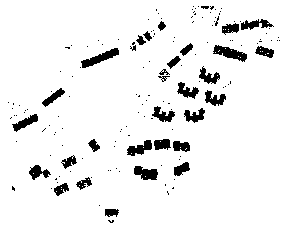

In [0]:
# Show predictions (binary, black and white) on whole input image.
plt.imshow(yhat[:, :, 0]>0.5, cmap='Greys')
plt.axis('off')
plt.savefig(path+'predictions/train_valid_binary_bw.png', **img_params)